In [36]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

In [37]:
df = pd.read_csv('Word_Embedding.csv')

In [71]:
lag_days_range = [1,2,3,4,5]
lagged_features = []

for lag_day in lag_days_range:
    df[f'Lag_{lag_day}_Perc_Change'] = df['Percentage_Change'].shift(lag_day)
    lagged_features.append(f'Lag_{lag_day}_Perc_Change')

mse_scores_trainset = []
mse_scores_testset = []
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30]
}
best_lag_day = None
best_params = None
best_avg_mse = float('inf')

for i in range(1, len(lag_days_range)+1):
    prev_days = lagged_features[:i]
    x = df[prev_days]
    y = df['Percentage_Change']

    x = x.dropna()
    y = y.loc[x.index]
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

    rf = RandomForestRegressor(random_state=42)
    # 10-fold cross-validation
    grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=10, scoring='neg_mean_squared_error')
    grid_search.fit(x_train, y_train)

    best_params = grid_search.best_params_
    best_score = -grid_search.best_score_
    mse_scores_trainset.append(best_score)

    print(f'{i}-day lagged percentage changes')
    print(f'Mean Squared Error on train set: {best_score}')

    # Use the best estimator to make predictions on the test set
    best_model = grid_search.best_estimator_
    y_pred_test = best_model.predict(x_test)
    
    # Evaluate the model on the test set
    mse_test = mean_squared_error(y_test, y_pred_test)
    mse_scores_testset.append(mse_test)
    print(f'Mean Squared Error on test set: {mse_test}')



1-day lagged percentage changes
Mean Squared Error on train set: 13.496421594115617
Mean Squared Error on test set: 11.709269160481066
2-day lagged percentage changes
Mean Squared Error on train set: 13.626013088595172
Mean Squared Error on test set: 12.316178712068568
3-day lagged percentage changes
Mean Squared Error on train set: 14.039717170578706
Mean Squared Error on test set: 10.561275606321276
4-day lagged percentage changes
Mean Squared Error on train set: 13.55014229563613
Mean Squared Error on test set: 11.808369454158948
5-day lagged percentage changes
Mean Squared Error on train set: 12.900184642957441
Mean Squared Error on test set: 13.985232339455614


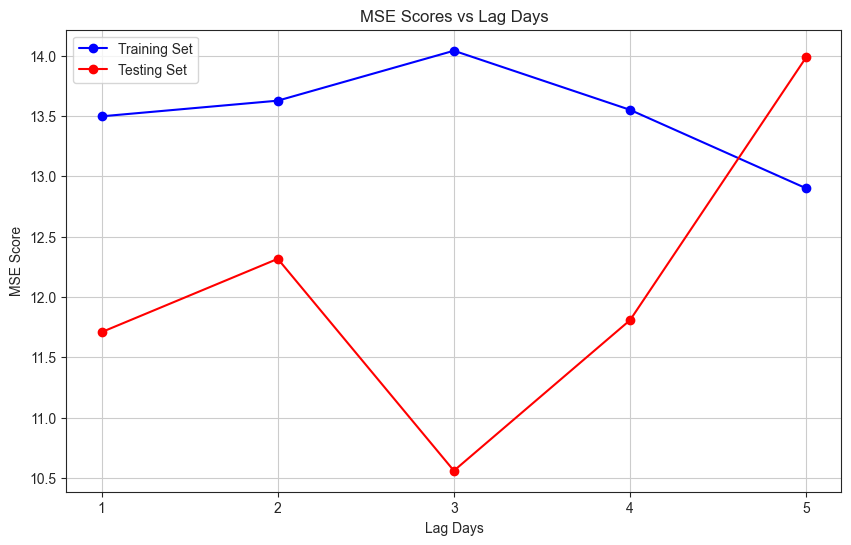

In [76]:
import matplotlib.pyplot as plt

# Plot mse_scores against lag_days_range
plt.figure(figsize=(10, 6))
plt.plot(lag_days_range, mse_scores_trainset, marker='o', color='b', label='Training Set')
plt.plot(lag_days_range, mse_scores_testset, marker='o', color='r', label='Testing Set')
plt.title('MSE Scores vs Lag Days')
plt.xlabel('Lag Days')
plt.ylabel('MSE Score')
plt.xticks(lag_days_range)
plt.grid(True)
plt.legend()
plt.show()

